# [Computational Social Science]
## 5-1 Text Preprocessing and Featurization - Solutions

This lab will cover the basics of text preprocessing and featurization, and introduce text classification.

## Virtual Environment
Remember to always activate your virtual environment first before you install packages or run a notebook! This helps to prevent conflicts between dependencies across different projects and ensures that you are using the correct versions of packages. You must have created anaconda virtual enviornment in the `Anaconda Installation` lab. If you have not or want to create a new virtual environment, follow the instruction in the `Anaconda Installation` lab. 

<br>

If you have already created a virtual enviornment, you can run the following command to activate it: 

<br>

`conda activate <virtual_env_name>`

<br>

For example, if your virtual environment was named as CSS, run the following command. 

<br>

`conda activate CSS`

<br>

To deactivate your virtual environment after you are done working with the lab, run the following command. 

<br>

`conda deactivate`

<br>

## Preparing your environment

You will need to uncomment the following lines download `SpaCy` if you do not already have it on your local machine. `NLTK` (Natural Language Toolkit) is an older, less efficient alternative. `SpaCy` is a simplier and optimized library compared to `NLTK`, which is more comprhensive but is a bit more verbose and has a slightly higher learning curve. 

In [1]:
# download libraries
# ----------
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [2]:
# load libraries
# ----------
import spacy
import en_core_web_sm
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

# settings
%matplotlib inline

## Data

<img src = "../../images/cfpb_logo.png"/>

For the next few labs, we will use the Consumer Financial Protection Bureau's [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/). The database is rich with information about individual consumer complaints about credit card fraud, debt collections, and other consumer issues. This dataset is convenient for text analysis because the consumer complaints are real text generated by real people. This means that the data have all the idiosyncrasies that come with those data-generating processes. It also contains multiple different categories that we can predict, like type of product the complaint is about and whether the complaint was resolved quickly. 

The basic process is that if someone has a dispute related to consumer finance (mortgages, student loans, credit cards, etc.), they can file a dispute with the CFPB, which then contacts the company named in the dispute to get some resolution of the issue.

In [3]:
# load the data
# ----------

# load the dataframe
cfpb = pd.read_csv("../../data/CFPB 2020 Complaints.csv")

# drop missing on "Consumer complaint narrative" feature and reset the index bc we've dropped
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative']).reset_index()

In [4]:
# view 
# ----------
cfpb.head()

,index,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,8,01/30/20,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,Reviewed my credit report in XX/XX/XXXX and no...,NaN,"EQUIFAX, INC.",AZ,850XX,NaN,Consent provided,Web,01/30/20,Closed with explanation,Yes,NaN,3515096
1,10,03/12/20,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,TransUnion has not properly investigated the i...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",IL,606XX,NaN,Consent provided,Web,03/12/20,Closed with explanation,Yes,NaN,3564439
2,14,05/01/20,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,XX/XX/2020 someone tried to steal my identity ...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",IL,606XX,NaN,Consent provided,Web,05/01/20,Closed with non-monetary relief,Yes,NaN,3633318
3,19,04/06/20,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,I paid the debt on XX/XX/XXXX. I disputed acco...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NY,NaN,Servicemember,Consent provided,Web,04/06/20,Closed with explanation,Yes,NaN,3594679
4,35,04/18/20,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,A COLLECTION HAS BEEN REPORTED TO MY CREDIT RE...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",FL,336XX,NaN,Consent provided,Web,04/18/20,Closed with explanation,Yes,NaN,3611900


In [5]:
# view examples just from "Consumer complaint" column 
# ----------
cfpb['Consumer complaint narrative'].head()

0    Reviewed my credit report in XX/XX/XXXX and no...
1    TransUnion has not properly investigated the i...
2    XX/XX/2020 someone tried to steal my identity ...
3    I paid the debt on XX/XX/XXXX. I disputed acco...
4    A COLLECTION HAS BEEN REPORTED TO MY CREDIT RE...
Name: Consumer complaint narrative, dtype: object

## Tokenization

Tokenization is the **process of splitting text into words and sentences.** These chunks (words, sentences, etc.) are called **tokens**. One approach might be to try to do this use string methods like [str.split](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html). The problem with this is that using a separator like a "," or "." or " " may not work for some common situations. So instead, we'll use the [spaCy](https://spacy.io/) library.

### Why tokenize?

Electronic text is a linear sequence of symbols. Before any processing can be done, text needs to be segmented into linguistic units, and this process is called tokenization.

We usually look at grammar and meaning at the level of words, related to each other within sentences, within each document. So if we're starting with raw text, we first need to split the text into sentences, and those sentences into words -- which we call "tokens".

### How to tokenize

#### Using String Methods

##### Split Into Sentences

You might imagine that the easiest way to identify sentences is to split the document at every period `"."`, and to split the sentences using white space to get the words.

In [6]:
# using the split function to create tokens
# ----------
text = cfpb['Consumer complaint narrative'][0]  # the [0] takes the very first record
sentences = text.split(".")                     # split by decimal point
for s in sentences[:5]:                         # take just the first 5 sentences
    print(s + '\n')                             # "\" sets it on a new line

Reviewed my credit report in XX/XX/XXXX and noticed a lot of errors, inconsistent, and incorrect information

 Sent a letter to Equifax on XX/XX/XXXX via mail asking them for an investigation and to verify all the dates and amounts were correct and fix the incorrect reporting on my credit

 They did not respond at all so I sent another letter on XX/XX/XXXX via mail, again asking for an investigation and proof

 They still didnt respond to that letter so I sent a third letter on XX/XX/XXXX certified mail so I have proof that they signed for my letter



Last week I received two letters from Equifax dated XX/XX/XXXX on the same day



This seems to be ok, but what if someone said something like "U.C. Berkeley charged me $50.11 by mistake."

In [7]:
# illustration of how this function breaks down
# ----------
bad_text = "U.C. Berkeley charged me $50.11 by mistake."
bad_sentences = bad_text.split(".")
for s in bad_sentences[:5]:
    print(s + '\n')

U

C

 Berkeley charged me $50

11 by mistake





That doesn't look too good! The one sentence was split into 4 separate sentences because `"."`'s are used for things other than ending a sentence.

##### Split Into Tokens
From here, we might split each sentence into tokens by splitting on white space in between words. Try filling in the code below to take the first sentence and split on white spaces.

In [8]:
# use a different parameter in the split function to create tokens using a " " (space)
# ----------
sentence = sentences[0]                 # take the first sentence from our "sentences" object
print("Sentence to split: ", sentence)  # visualize the sentence we we splitting
tokens = sentence.split(" ")            # split by " " a space this time
tokens                                  # print the token

Sentence to split:  Reviewed my credit report in XX/XX/XXXX and noticed a lot of errors, inconsistent, and incorrect information


['Reviewed',
 'my',
 'credit',
 'report',
 'in',
 'XX/XX/XXXX',
 'and',
 'noticed',
 'a',
 'lot',
 'of',
 'errors,',
 'inconsistent,',
 'and',
 'incorrect',
 'information']

**CHALLENGE 1:** What was the problem with splitting on the white space? Are there any tokens that look a little strange?

**ANSWER**: **ANSWER**: We may not want some words to have commas after them like "errors," and "inconsistent," but this approach does not let us easily address those issues. Instead, using the `str.split` method will (1) likely create new issues that we will have to solve and (2) is not easily generalized to other situations.

#### spaCy

In contrast to simple string methods, `spaCy` uses pre-trained language models to incorporate context. In this case, we'll load the [en_core_web_sm](https://spacy.io/models/en), which is one of `spaCy`'s English language models. For instance, the end of a sentence (".") should mark a new token, but the string "U.K." should not be separated at the `"."`'s. According to [spaCy's documentation](https://spacy.io/usage/spacy-101#annotations-token) it achieves this by taking the following steps:

First, the raw text is split on whitespace characters, similar to `text.split(' ')`. Then, the tokenizer processes the text from left to right. On each substring, it performs two checks:

1. Does the substring match a tokenizer exception rule? For example, “don’t” does not contain whitespace, but should be split into two tokens, “do” and “n’t”, while “U.K.” should always remain one token.
2. Can a prefix, suffix or infix be split off? For example, punctuation like commas, periods, hyphens or quotes.

If there’s a match, the rule is applied and the tokenizer continues its loop, starting with the newly split substrings. This way, `spaCy` can split complex, nested tokens like combinations of abbreviations and multiple punctuation marks.

Now let's try applying these methods to our CFPB data. The steps to do this are:

1. Load the language model.
2. Apply it to a piece of text and save it in an `spaCy` "doc" object.
3. Extract each token from the doc object to a list.
4. Display the tokens

Check the documentation for help filling in these steps!

Note this next step might take a few moments to run.

In [9]:
# use a different parameter in the split function to create tokens using a " " (space)
# ----------
nlp = en_core_web_sm.load()                 # load the small language model en_core_web_sm

doc = nlp(text)                             # apply the nlp language model to process the text object from above
spacy_words = [token.text for token in doc] # create a list of words from doc object (this is a list comprehension)
display(f"Tokenized words: {spacy_words}")  # fancier way to displaying an object using the f-string formatting
#print(spacy_words)                         # another way that you might be more familier with

# note that "token.text" is an attribute of "token" not the object text we are cleaning
# see--https://spacy.io/api/token--for more details

# general syntax for list comprehension: [expression for item in iterable]

"Tokenized words: ['Reviewed', 'my', 'credit', 'report', 'in', 'XX', '/', 'XX', '/', 'XXXX', 'and', 'noticed', 'a', 'lot', 'of', 'errors', ',', 'inconsistent', ',', 'and', 'incorrect', 'information', '.', 'Sent', 'a', 'letter', 'to', 'Equifax', 'on', 'XX', '/', 'XX', '/', 'XXXX', 'via', 'mail', 'asking', 'them', 'for', 'an', 'investigation', 'and', 'to', 'verify', 'all', 'the', 'dates', 'and', 'amounts', 'were', 'correct', 'and', 'fix', 'the', 'incorrect', 'reporting', 'on', 'my', 'credit', '.', 'They', 'did', 'not', 'respond', 'at', 'all', 'so', 'I', 'sent', 'another', 'letter', 'on', 'XX', '/', 'XX', '/', 'XXXX', 'via', 'mail', ',', 'again', 'asking', 'for', 'an', 'investigation', 'and', 'proof', '.', 'They', 'still', 'did', 'nt', 'respond', 'to', 'that', 'letter', 'so', 'I', 'sent', 'a', 'third', 'letter', 'on', 'XX', '/', 'XX', '/', 'XXXX', 'certified', 'mail', 'so', 'I', 'have', 'proof', 'that', 'they', 'signed', 'for', 'my', 'letter', '.', '\\n\\n', 'Last', 'week', 'I', 'received

#### Removing Stop Words and Punctuation

We now have some tokens with just a few lines of code! There are a few additional steps that we might want to take. For example, we may want to remove punctuation and stop words. Punctuation oftentimes does not add substantive information to a piece of text, and stop words are common words that appear very frequently across texts. Removing this kind of information can help with downstream classification tasks by allowing an algorithm to focus on words that distinguish documents, rather than ones that appear frequently across them. 

Note that we might all have different opinions on the precise list of stop words, but in general this library should cover the basics. 

First, let's take a look at stop words. We can start by importing a collection of stop words from spaCy by running the following code:

In [10]:
# load STOP_WORDS module from spaCy library
# ----------
from spacy.lang.en.stop_words import STOP_WORDS

Now let's look at some common stop words from this collection:

In [11]:
# list stop words 1-11 from the library
# ----------
list(STOP_WORDS)[0:10]

['due',
 'regarding',
 "'ll",
 'n‘t',
 'whereby',
 'that',
 'above',
 'into',
 'my',
 'top']

Note that the list of words you might sight will differ because `STOP_WORDS` is a set and not a list. A [set](https://www.w3schools.com/python/python_sets.asp) is an **unordered,** **unchangable,** and **unindexed** data structure in python. Sets are particularlly useful because it is faster to search for an element in a set than a list because sets are organized over hash tables instead of linear indices. 

We can do the same for punctuation:

In [12]:
# load punctuation module from string library
# ----------
from string import punctuation  # note that this is a base library
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Removing punctuation and stop words is not a hard and fast rule - there may be situations where you want to keep them. In most applications, they add noise to downstream tasks, but always be mindful of your particular application when making decisions. Now that we have some tokenization tools, let's put them all together in a function!

**CHALLENGE 2:** Write a function that takes a piece of text as an argument, and returns a list of tokens without punctuation or stop words.

In [13]:
# load punctuation module from string library
# ----------

# initalize an empty list
tokens_reduced = []

# create a function to remove punctuation and stop words 
def rem_punc_stop(text):

    # set objects
    stop_words = STOP_WORDS         # set STOP_WORDS to a new object variable
    punc = set(punctuation)         # convert punctuation to a set
    
    # essentially remove the punctuation - important to remove punctuation first to correctly capture stop words
    punc_free = "".join([ch for ch in text if ch not in punc]) # join new list of characters (ch) in text w/ condition
                                                               # if ch is not in punctuation 
                                                               # "".join() creates a string from the list comprehension

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # extract words from processed text 
    spacy_words = [token.text for token in doc]
    
    # filter out words 
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    # return
    return no_punc

In [14]:
# apply function
# ----------

# apply our new function to our text object from above
tokens_reduced = rem_punc_stop(text)

# view the first 5 tokens
tokens_reduced[0:5]

['Reviewed', 'credit', 'report', 'XXXXXXXX', 'noticed']

## Entity Recognition

`spaCy` also contains a number of methods for things like entity recognition. For instance, we could run the following code to check various entities. Notice that this process isn't perfect, `spaCy` still thinks "XX/XX/XXXX" is an organization or product even though we know this is a redacted date.

In [15]:
# apply function to text object
# ----------
for entity in nlp(text).ents:
    print(entity.text + ' - ' + entity.label_ + ' - ' + str(spacy.explain(entity.label_)))

XX - GPE - Countries, cities, states
Equifax - ORG - Companies, agencies, institutions, etc.
XX - GPE - Countries, cities, states
XX - GPE - Countries, cities, states
third - ORDINAL - "first", "second", etc.
XX - GPE - Countries, cities, states
Last week - DATE - Absolute or relative dates or periods
two - CARDINAL - Numerals that do not fall under another type
Equifax - ORG - Companies, agencies, institutions, etc.
XX - GPE - Countries, cities, states
the same day - DATE - Absolute or relative dates or periods
three - CARDINAL - Numerals that do not fall under another type
Arizona - GPE - Countries, cities, states
XXXX - ORG - Companies, agencies, institutions, etc.
second - ORDINAL - "first", "second", etc.


In [16]:
# How can we modify the above code to apply function to the cleaned tokens_reduced object?
# ----------

# first, convert tokens_reduced from list to a string
tokens_reduced_str = str(tokens_reduced)

# next, apply function
for entity in nlp(tokens_reduced_str).ents:
    print(entity.text + ' - ' + entity.label_ + ' - ' + str(spacy.explain(entity.label_)))
    

'Reviewed', 'credit' - WORK_OF_ART - Titles of books, songs, etc.
XXXXXXXX - PERSON - People, including fictional
XXXXXXXX - PERSON - People, including fictional
XXXXXXXX - PERSON - People, including fictional
XXXXXXXX - PERSON - People, including fictional
'week' - DATE - Absolute or relative dates or periods
XXXXXXXX - PERSON - People, including fictional
'day' - DATE - Absolute or relative dates or periods
Arizona - GPE - Countries, cities, states
second - ORDINAL - "first", "second", etc.
'How' - WORK_OF_ART - Titles of books, songs, etc.


## Lemmatization

Another preprocessing step we might take is reducing words down to their lemmas. Lemmatization reduces a word to its root word, while making sure the word still belongs to the language. This is in contrast to stemming, which reduces the word down to its root even if that root is not a valid word. Consider the following example:

In [17]:
# run a loop to identify the shortest variatiant of each word 
# ----------
for word in nlp(u'compute computer computed computing'):
    print(word.text,   # print the word 
          word.lemma_) # print the lemma 

compute compute
computer computer
computed compute
computing computing


Stemming these words would all result in the root "comput" but lemmatization converted these words to their shortest variant. Again, you may choose to stem or lemmatize depending on your specific application. 

Now, try it again but with a new set of words:

In [18]:
# try it again with a new word to see how it changes 
# ----------
for word in nlp(u'played playing plays'):
    print(word.text,   # print the word 
          word.lemma_) # print the lemma 

played play
playing play
plays play


**CHALLENGE 3:** Lemmatize the first consumer complaint narrative.

In [19]:
# now run a loop to identify the shortest variant of each word  from 
# ----------
for word in nlp(text):
    print(word.text,  
          word.lemma_)

Reviewed review
my my
credit credit
report report
in in
XX XX
/ /
XX XX
/ /
XXXX XXXX
and and
noticed notice
a a
lot lot
of of
errors error
, ,
inconsistent inconsistent
, ,
and and
incorrect incorrect
information information
. .
Sent send
a a
letter letter
to to
Equifax Equifax
on on
XX XX
/ /
XX XX
/ /
XXXX XXXX
via via
mail mail
asking ask
them they
for for
an an
investigation investigation
and and
to to
verify verify
all all
the the
dates date
and and
amounts amount
were be
correct correct
and and
fix fix
the the
incorrect incorrect
reporting reporting
on on
my my
credit credit
. .
They they
did do
not not
respond respond
at at
all all
so so
I I
sent send
another another
letter letter
on on
XX XX
/ /
XX XX
/ /
XXXX XXXX
via via
mail mail
, ,
again again
asking ask
for for
an an
investigation investigation
and and
proof proof
. .
They they
still still
did do
nt not
respond respond
to to
that that
letter letter
so so
I I
sent send
a a
third third
letter letter
on on
XX XX
/ /
XX XX
/

## Chunking

We may also want to chunk more than one word together. One way to do this might be to group nouns together. 

**CHALLENGE 4:** Trying using the [`noun_chunks`](https://spacy.io/api/doc#noun_chunks) method to chunk nouns in the first complaint.

In [20]:
# chunking
# ----------
# apply the nlp to our text object to convert to a spacy object
doc = nlp(text)

# run a loop to chunk and print the obejct
for np in doc.noun_chunks:
    print(np.text)

my credit report
XX/XX/XXXX
a lot
errors
inconsistent, and incorrect information
a letter
Equifax
XX/XX/XXXX
mail
them
an investigation
all the dates
amounts
the incorrect reporting
my credit
They
I
another letter
XX/XX/XXXX
mail
an investigation
proof
They
that letter
I
a third letter
XX/XX/XXXX certified mail
I
proof
they
my letter
I
two letters
Equifax
dated XX/XX/XXXX
the same day
The
they
my credit file
me
proof
identification
address
all three letters
I
a copy
my Arizona drivers license
my XXXX direct deposit sub
my proof
address
The second letter
they
my request
the promotions list
it
my credit file
they
my file
the restriction
they
my credit file
regards
investigation purposes


## Bag of Words

Now that we have covered some the basics of text preprocessing, we are ready to start getting our data in a format for feeding it into machine learning algorithms. There are many options for converting raw text to features in a supervised machine learning problem. The most basic of these is the "bag of words" approach. Bag of words essentially counts the number of times each word appears in a corpus, and these counts become features.

To illustrate, first let's import the CounterVectorizer method from sklearn. Once we do that, let's use our tokenizer function that we wrote earlier to initialize the [CountVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [21]:
# load libraries
# ----------
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [22]:
# initalize CountVectorizer and specify some parameters
# ----------
bow_vector = CountVectorizer(tokenizer = rem_punc_stop, # use our function for tokenizing created above
                             token_pattern = None,      # set to "None" since we have specify our own pattern
                             ngram_range=(1,1))         # use default for unigrams - see documentation

Once we create a CountVectorizer object, we can then transform a list of texts with the "fit_transform" method. This will return a sparse matrix with the counts. We can densify the matrix with the ".todense()" method.

In [23]:
# fit and transform just a subset of our data
# ----------
bow_matrix = bow_vector.fit_transform(cfpb['Consumer complaint narrative'][0:5]) 

In [24]:
# visualize
# ----------
bow_matrix.todense() # todense() densifies the sparse matrix (which only stores non-zeros elements)

matrix([[ 0,  1,  0,  0,  0,  1,  1,  2,  1,  1,  2,  0,  0,  1,  0,  0,
          0,  1,  1,  5,  1,  1,  1,  0,  1,  1,  0,  0,  0,  1,  2,  1,
          4,  0,  2,  1,  0,  0,  1,  0,  1,  2,  1,  0,  0,  3,  0,  6,
          2,  1,  1,  1,  1,  3,  1,  1,  2,  0,  0,  0,  0,  1,  4,  0,
          1,  0,  2,  0,  1,  0,  1,  1,  0,  1,  1,  0,  2,  1,  0,  1,
          2,  1,  1,  4,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,
          1,  1,  0,  0,  5],
        [ 0,  1,  2,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,
          0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  1,  0,  0,  1,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  7,  0,
          0, 26,  7,  0,  0],
        [ 1,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,

We can also get the feature names:

In [25]:
# get feature names instead and view subset
# ----------
feature_names = bow_vector.get_feature_names_out()
feature_names[0:10] 

array(['\n', '\n\n', ' ', 'account', 'accounts', 'add', 'added',
       'address', 'amounts', 'arizona'], dtype=object)

In [26]:
# Code to concatenate bag of words matrix with column names to visualize
# ----------
bow_df = pd.DataFrame(bow_matrix.toarray(),  # make bow_matrix an array 
                      columns=feature_names) # set column names to feature names just extracted
bow_df

,\n,\n\n,,account,accounts,add,added,address,amounts,arizona,...,thorough,transunion,tried,unauthorized,verify,week,xxxx,xxxx2018,xxxx2020,xxxxxxxx
0,0,1,0,0,0,1,1,2,1,1,...,0,0,0,0,1,1,1,0,0,5
1,0,1,2,0,1,0,0,0,0,0,...,1,1,0,7,0,0,26,7,0,0
2,1,0,4,0,0,0,0,0,0,0,...,0,2,1,0,0,0,21,0,1,2
3,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Term Frequency - Inverse Document Frequency

An extension of bag-of-words is the term frequency-inverse document frequency approach. Whereas bag-of-words counts the number of words in the document, tf-idf takes this quanity and divides it by how frequently the word shows up across the corpus. In doing so, the tf-idf score downweights words that are common in the corpus and thus would not aid with classification.

**CHALLENGE 5:** Using the code from the "Bag of Words" section as a template, write code to get the tf-idf matrix for the CFPB data. You may want to check the documentation for [TfidfVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to see other options.

In [27]:
# initalize TfidfVectorizer and specify some parameters
# ----------
tfidf_vector = TfidfVectorizer(tokenizer = rem_punc_stop, # use our function for tokenizing created above
                               token_pattern = None)      # set to "None" since we have specify our own pattern to prevent error

In [28]:
# fit and transform just a subset of our data
# ----------
# fit and transform to obtain the tfidf matrix
matrix = tfidf_vector.fit_transform(cfpb['Consumer complaint narrative'][0:5])

# if you want to get the feature names and check the length
feature_names = tfidf_vector.get_feature_names_out()
len(feature_names)

101

In [29]:
# visualize
# ----------
matrix.todense() # todense() densifies the sparse matrix (which only stores non-zeros elements)

matrix([[0.        , 0.0591843 , 0.        , 0.        , 0.        ,
         0.07335741, 0.07335741, 0.14671482, 0.07335741, 0.07335741,
         0.14671482, 0.        , 0.        , 0.07335741, 0.        ,
         0.        , 0.        , 0.07335741, 0.07335741, 0.20664143,
         0.07335741, 0.07335741, 0.07335741, 0.        , 0.07335741,
         0.07335741, 0.        , 0.        , 0.        , 0.07335741,
         0.14671482, 0.07335741, 0.29342964, 0.        , 0.14671482,
         0.07335741, 0.        , 0.        , 0.07335741, 0.        ,
         0.07335741, 0.11836859, 0.07335741, 0.        , 0.        ,
         0.22007223, 0.        , 0.35510578, 0.14671482, 0.07335741,
         0.07335741, 0.07335741, 0.07335741, 0.22007223, 0.07335741,
         0.07335741, 0.14671482, 0.        , 0.        , 0.        ,
         0.        , 0.07335741, 0.29342964, 0.        , 0.07335741,
         0.        , 0.14671482, 0.        , 0.07335741, 0.        ,
         0.04912831, 0.0349552 , 0

## Basic Classification (optional)

This section is optional because we won't cover Naive Bayes until later in the semester but it will give you a sense of where we are going and what we can do with cleaned data. 

So, now that we have featurized our text, we are ready to make a prediction! Does the text of our consumer complaints predict whether or not they get a timely response?

**CHALLENGE 6:** Transform the text of the consumer complaint narrative into a tf-idf matrix, and use it to predict the "Timely response?" column.

In [30]:
#
# Naive Bayes Classification workflow
# --------------------------------------------

# subset the data for speed of analysis
# ----------
cfpb = cfpb[:5000]


# features
# ----------
X = cfpb['Consumer complaint narrative']        # select just the consumer complaint column
tf = TfidfVectorizer(tokenizer = rem_punc_stop, # initialize the TfidfVectorizer() algorithm and use our cleaning algorithim
                     token_pattern = None)      # set to "None" since we have specify our own pattern

# fit tokenizer on X dataframe
tfidf_matrix =  tf.fit_transform(X)             # fit and transform the features

# label
# ----------
y = cfpb['Timely response?']                   # subset so outcome object only includes timely response label

# create train-test split
# ----------
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix,     # tranformed feature matrix
                                                    y,                # labels
                                                    train_size = .80, # training split
                                                    test_size = .20,  # testing split
                                                    random_state=100)   # set random state

# create train-validation split
# ----------
X_train, X_validate, y_train, y_validate = train_test_split(X_train,          # feature training data
                                                            y_train,          # outcome training data
                                                            train_size = .75, # training split
                                                            test_size = .25,  # testing split
                                                            random_state=101)   # set random state



In [31]:
# set seed for reproducibility
# ----------
from spacy.util import fix_random_seed # important random seed utility from spacy library
fix_random_seed(1) # set seed

# initialize the Multinomial Naive Bayes algorithim
# ----------
nb = MultinomialNB()

# fit it on the training data
# ----------
nb_model = nb.fit(X_train, 
                  y_train)

# predict on validation dataset
# ----------
nb_pred = nb_model.predict(X_validate)

In [32]:
# import numpy library
# ----------
import numpy as np

# print average accuracy
# ----------
print(np.mean(nb_pred == y_validate))

# create a confusion matix
# ----------
nb_cf_matrix = confusion_matrix(y_validate, 
                                nb_pred, 
                                normalize = "pred") # normalize by column
nb_cf_matrix

0.988


array([[0.   , 0.012],
       [0.   , 0.988]])

In [33]:
# convert to dataframe for visualization
# ----------
nb_df_cm = pd.DataFrame(nb_cf_matrix, 
                        range(2),
                        range(2))

# visualize
nb_df_cm

,0,1
0,0.0,0.012
1,0.0,0.988


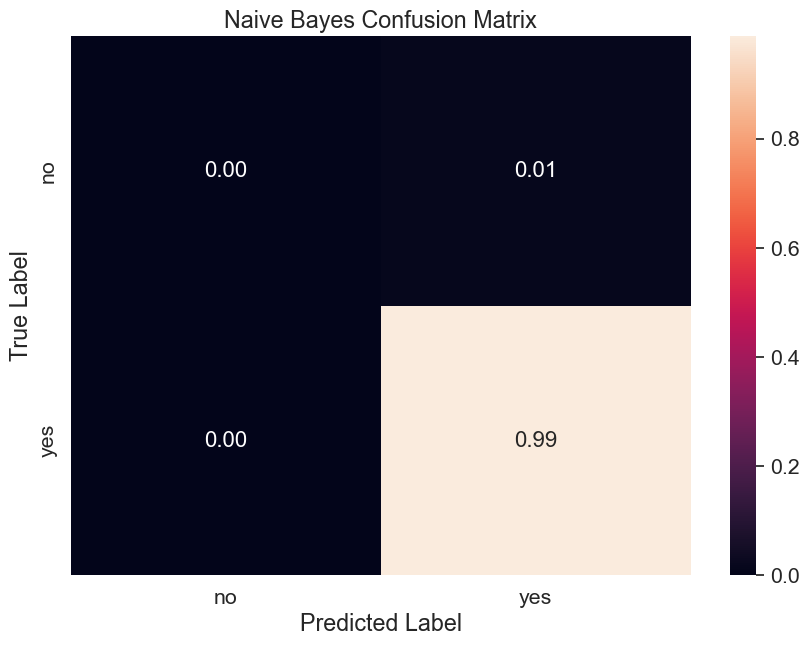

In [34]:
# create confusion matrix using Seaborn code
# ----------
# add indices and labels
nb_df_cm = nb_df_cm.rename(index=str, columns={0: "no", 1: "yes"})
nb_df_cm.index = ["no", "yes"]

# specifyc figure parameters
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size

# specify figure using seaborn library
sn.heatmap(nb_df_cm, 
           annot=True,
           annot_kws={"size": 16}, 
           fmt='.2f')  # prevent scientific notation

# figure labels
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()